# CSMODEL
## Project 1 - Group 5

### Members:
- Alon-alon, Jason Miguel E.
- Escalona, Jose Miguel A.
- Llorca, Marcelino Francis S.

### 1. Dataset Representation

- About the Dataset<br>

The data was provided by Our World in Data (OWID). The file contains different data values that could help paint a better image of a country’s status for COVID-19. The version used in this project will be the July 15, 2021 release of the dataset, however OWID attempts both daily and weekly update of data whenever possible, thus ensuring that the data they provide is the latest possible.

- Collection Process and its Implications<br>

The collection was done by the Our World in Data Group which is a research group that focuses on research and aggregation of data in a single accessible repository for the purposes of getting a better picture or even solving world problems that can benefit all of mankind. For the specific dataset, they made use of all possible available data that is publicly released by governments of all nations in the world. According to OWID, the data was collected from the following sources which include:
    
    1. COVID-19 Data Repository of Johns Hopkins University
    2. National Government Reports
    3. Oxford COVID-19 Government Response Tracker, Blavatnik School of Government
    4. United Nations Data (for demographics related data)
    5. World Bank Data (for demographics related data)
    
The data implies that the data presented assumes to be the latest data possible, with its validity ultimately depending on each government's transparency and accuracy with the data they are reporting publicly and to John Hopkins University.
    <br>
- Structure of Dataset of the File<br>

    The dataset's structure consists of 102,475 observations with 60 variables available. The structure goes on every country's date when it reported either its first COVID-19 case or first COVID-19 test. The dataset was already distributed publicly on a single file containing all of the relevant information possible. There is however other datasets which contain specific and specialized versions of the current dataset we are using that is also available for use on OWID's Github repository.
    
    | iso_code | continent | location | date | data1 | ... | dataX |
    | --- | --- | --- | --- | --- | --- | --- |
    | PHL | Asia | Philippines | 0000-00-01 | data | ... | dataX |
    | PHL | Asia | Philippines | 0000-00-02 | data | ... | dataX |
    | JPN | Asia | Japan | 0000-00-01 | data | ... | dataX |
    | JPN | Asia | Japan | 0000-00-02 | data | ... | dataX |
    | SGP | Asia | Singapore | 0000-00-01 | data | ... | dataX |
    | SGP | Asia | Singapore | 0000-00-02 | data | ... | dataX |
    | SGP | Asia | Singapore | 0000-00-03 | data | ... | dataX |

    The list of locations are a mixture of continents and actual countries, as recognized by OWID, which may or may not be legally recognized by the international community.
    <br>
- About the Variables<br>
    
    The dataset has 60 variables, most of which relate to COVID-19 related numbers such as cases, deaths, recoveries, vaccinations among others, as well as demographic data such as GDP per capita, HDI, median age, population, population density among others.

In [1]:
print("LOADING LIBRARIES...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ttest_ind

bar = "================================="
automated = True #Manual entry or pre-defined entries
print("AUTOMATED MODE:",automated)

#Code for data preparation
#PREPARE FILES AND RAW DATAFRAME
raw_df = None
if(not automated):
    filename = input("Enter Filename of CSV file (including .csv): ")
    raw_df = pd.read_csv(filename)
else:
    raw_df = pd.read_csv("COVID_7_15.csv")
#Raw file reading: make use of covid_df.readline() to retrieve a str line (as str) from

print("Raw Dataframe Shape:", raw_df.shape,"\n",bar)
print(raw_df.info())
print("Location List:",raw_df["location"].unique())

LOADING LIBRARIES...
AUTOMATED MODE: True
Raw Dataframe Shape: (102475, 60) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102475 entries, 0 to 102474
Data columns (total 60 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               102475 non-null  object 
 1   continent                              97689 non-null   object 
 2   location                               102475 non-null  object 
 3   date                                   102475 non-null  object 
 4   total_cases                            98594 non-null   float64
 5   new_cases                              98591 non-null   float64
 6   new_cases_smoothed                     97581 non-null   float64
 7   total_deaths                           88371 non-null   float64
 8   new_deaths                             88527 non-null   float64
 9   new_deaths_smoothed                    97581 non

### 2. Data Cleaning

Given that there are a lot of nations and variables to consider, it has been decided to reduce to scope of nations to just the ASEAN nations as well as the World as a baseline. The consideration for ASEAN nations was made because of the following reasons:

1. Near proximity
2. Economic integration
3. Similar level economies and populations

This could help us determine the COVID-19 status of the Philippines to its neighbors as well as the World if ever it is applicable.

The most of the columns are to be ommitted since it contains pre-treated values, specialized values, or varying values (in terms of the unit of measurement).

The columns that were retained:
- 'total_cases'
- 'new_cases'
- 'total_deaths'
- 'new_deaths'
- 'total_vaccinations'
- 'people_vaccinated'
- 'people_fully_vaccinated'
- 'new_vaccinations'
- 'stringency_index'
- 'population'
- 'gdp_per_capita'

The script below crunches the raw data and produces a covid_df containing:
1. World COVID-19 Data (from OWID)
2. ASEAN COVID-19 Data (Containing 10 Countries, including the Philippines)
3. Philippine COVID-19 Data

Do note however that any observation on a certain day that does not meet the required number of observations (i.e. countries that reported that day) will be automatically omitted from the resulting group dataframe. This was done in order to prevent outliers in the data and to reduce the erraticness of the output which matters since most of the data is of sum and mean value nature.

In [2]:
#CSMODEL: COVID-19 Dataset
#Crunches data of selected countries to a grouped one

print("LOADING ADDITIONAL LIBRARIES...")
import re #For regex

#GLOBAL VARIABLES
checkpoint = False
print("CHECKPOINT:",checkpoint)
NaN = float("nan")
group_pop = 0 #Placeholder for the population of group of nations specified.

#CUSTOM FUNCTIONS
def listDates(df): #Sorts the 'date' column of a given DataFrame and returns it.
    date_sorted = df['date'].unique()
    date_sorted = np.sort(date_sorted,kind='mergesort')
    return date_sorted
def fillZeros(size): #Returns a list of zeros from a specified size
    return np.zeros(size).tolist()
def writeCheckpoint(df, filename): #Writes a given DataFrame to a CSV file
    if(checkpoint):
        print("WRITING CHECKPOINT...")
        df.to_csv(filename+".csv",index=False)
        print("Checkpoint Complete:",filename)
def aggregator(src_df,iso_code,continent,location,count): #Aggregates the given DataFrame to a grouped version
    tmp_df = pd.DataFrame(columns=toRetain) 
    for i in range(dateCount):
        sp_date = date_values[i] #Specified date
        filtered_df = src_df[src_df['date']==sp_date] #Series of nations with specified date
        observations = filtered_df.shape[0]
        if(observations == count): #Will run only if all countries listed are there
            id = [iso_code,continent,location,sp_date] #Default identifiers for ASEAN
            data = fillZeros(len(toRetainData))
            for j in range(observations):
                #add current data with the retrieved data
                retrieve = filtered_df[toRetainData].iloc[j].tolist()
                #print(retrieve)
                data = list(map(lambda x,y:x+y,retrieve,data))
            #Make values in average if they are based on trends (Keyword: new, per_xxxx)
            #0-3 = iso_code,continent,location,date; equated to id
            data[1] = data[1]/observations #new cases
            data[3] = data[3]/observations #new deaths
            data[6] = data[6]/observations #new_vaccinations
            data[8] = data[8]/observations #stringency_index
            data[9] = group_pop #population
            data[10] = data[10]/observations #gdp_per_capita
            result = id+data
            tmp_df.loc[tmp_df.shape[0]] = result #"ADDS" THE RESULTING LIST AT THE END OF THE DATAFRAME
    return tmp_df
def dateRange(df): #Finds the lowest and highest date recorded.
    date_values = df['date'].unique()
    date_values = np.sort(date_values,kind='mergesort')
    dateCount = date_values.size
    return [date_values[0], date_values[len(date_values)-1]] #the latest possible data maybe incomplete thus the day prior the latest will be used

#PREPARE FILES AND RAW DATAFRAME
covid_df = raw_df.copy(deep=True)
#Raw file reading: make use of covid_df.readline() to retrieve a str line (as str) from

#DATE SORTING AND VALUES
date_values = listDates(covid_df)
dateCount = date_values.size

#COLUMNS TO RETAIN
toRetain = ['iso_code','continent','location','date','total_cases','new_cases','total_deaths','new_deaths','total_vaccinations','people_vaccinated','people_fully_vaccinated','new_vaccinations','stringency_index',
            'population','gdp_per_capita']
toRetainData = toRetain[4:]
identifiers = toRetain[0:4]
#LIST OF ONLY DATA THAT CAN BE USED IN A COLLECTIVE MANNER (AS USED BY OWID ITSELF)
forCollective = ['total_cases','new_cases','new_cases_smoothed','total_deaths','new_deaths','new_deaths_smoothed','total_cases_per_million'
                ,'new_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million','new_deaths_per_million','new_deaths_smoothed_per_million','total_vaccinations'
                ,'people_vaccinated','people_fully_vaccinated','new_vaccinations','new_vaccinations_smoothed','total_vaccinations_per_hundred','people_vaccinated_per_hundred'
                ,'people_fully_vaccinated_per_hundred','new_vaccinations_smoothed_per_million','population']
#LIST OF COUNTRIES TO RETAIN
targetCountries = ['PHL','BRN','KHM','IDN','SGP','LAO','THA','MYS','MMR','VNM']

#DROP COLUMNS
print("DROPPING COLUMNS...")
toDrop = list(set(covid_df.columns.tolist()) - set(toRetain))
covid_df = covid_df.drop(columns=toDrop)

#FILTERING COUNTRIES
print("FILTERING COUNTRIES...")
ph_df = covid_df[covid_df['iso_code']=='PHL'] #PH ONLY
world_df = covid_df[covid_df['iso_code'].str.contains('OWID_WRL')] #OVERALL WORLD DATA BY OWID
covid_df = covid_df[covid_df['iso_code'].str.contains(re.compile('|'.join(targetCountries)),regex=True)] #ASEAN NATIONS; YOU CAN CHANGE LIST OF COUNTRIES TO FOCUS

#FIND TOTAL POPULATION OF ASEAN
pop = covid_df[covid_df['date']==dateRange(covid_df)[1]]
if(pop.shape[0] != len(targetCountries)): #REFERENCES TO targetCountries
    print("COUNTRIES!=",len(targetCountries),"AT MAX DATE!")
    exit()
group_pop = pop['population'].sum()

#DATA CLEANUP: NaN->0
print("DATA CLEANUP (NaN->0)...")
for i in range(0,len(toRetain),1):
    covid_df.loc[covid_df[toRetain[i]].isnull(),toRetain[i]]=0

#READING CONENTS OF EACH OBSERVATION AVAILABLE OF ALL COUNTRIES AVAILABLE ON A GIVEN DATE 
#NOT THE MOST EFFICIENT ALGO AS IT RUNS AT O(n*m)
#WILL MAKE USE OF THE CURRENT LIST OF COUNTRIES AVAILABLE AT covid_df.
print("AGGREGATING ASEAN COUNTRIES...")
group_df = aggregator(covid_df,"MDL_SEA",NaN,"Asia",len(targetCountries)) #Will hold the resulting aggregation of ASEAN countries

#ASEAN Checkpoint
writeCheckpoint(group_df,"asean_checkpoint")

#Combined dataframes
print("COMBINING DATAFRAMES...")
complete_df = pd.concat([covid_df,group_df,world_df])
print("Complete iso_code:",complete_df['iso_code'].unique())

print("FILE PROCESSING COMPLETE!")

print("DATAFRAMES AVAILABLE FOR USE: covid_df, world_df, group_df, ph_df, complete_df")

LOADING ADDITIONAL LIBRARIES...
CHECKPOINT: False
DROPPING COLUMNS...
FILTERING COUNTRIES...
DATA CLEANUP (NaN->0)...
AGGREGATING ASEAN COUNTRIES...
COMBINING DATAFRAMES...
Complete iso_code: ['BRN' 'KHM' 'IDN' 'LAO' 'MYS' 'MMR' 'PHL' 'SGP' 'THA' 'VNM' 'MDL_SEA'
 'OWID_WRL']
FILE PROCESSING COMPLETE!
DATAFRAMES AVAILABLE FOR USE: covid_df, world_df, group_df, ph_df, complete_df


**The following dataframes could be used for the proceeding code:**
- covid_df = Choosen Countries COVID data (ASEAN in this case)
- group_df = Overall ASEAN COVID data
- world_df = Overall World COVID data
- ph_df = Philippine COVID data
- complete_df = Dataframes covid_df, group_df, world_df combined

In [3]:
#Sorting DataFrames by Date
def minmaxDates(capsule, capsule_str):
    for i in range(len(capsule)):
        print(capsule_str[i],":",capsule[i]['date'].iloc[0],"=>",capsule[i]['date'].iloc[capsule[i].shape[0]-1])

covid_df.sort_values(by='date')
group_df.sort_values(by='date')
world_df.sort_values(by='date')
ph_df.sort_values(by='date')
complete_df.sort_values(by='date')

capsule = [covid_df, group_df, world_df, ph_df,complete_df]
capsule_str = ['covid_df','group_df','world_df','ph_df','complete_df']

minmaxDates(capsule,capsule_str)

covid_df : 2020-03-09 => 2021-07-14
group_df : 2020-03-27 => 2021-07-14
world_df : 2020-01-22 => 2021-07-14
ph_df : 2020-01-30 => 2021-07-14
complete_df : 2020-03-09 => 2021-07-14


Based from the output above, the only valid data that is possible to use are those starting April 1 of 2020 up to July 1 of 2021.

In [4]:
#DROPPING OBSERVATIONS THAT FALL BELOW THE RECOMMENDED MINIMUM DATE
minDate = '2020-04-01'
maxDate = '2021-07-01'
covid_df = covid_df[(covid_df['date'] >= minDate) & (covid_df['date'] <= maxDate)]
group_df = group_df[(group_df['date'] >= minDate) & (group_df['date'] <= maxDate)]
world_df = world_df[(world_df['date'] >= minDate) & (world_df['date'] <= maxDate)]
ph_df = ph_df[(ph_df['date'] >= minDate) & (ph_df['date'] <= maxDate)]
complete_df = complete_df[(complete_df['date'] >= minDate) & (complete_df['date'] <= maxDate)]

capsule = [covid_df, group_df, world_df, ph_df, complete_df]
minmaxDates(capsule,capsule_str)

print("\nDataFrame Shapes")
print("covid_df:",covid_df.shape)
print("group_df:",group_df.shape)
print("world_df:",world_df.shape)
print("ph_df:",ph_df.shape)
print("complete_df:",complete_df.shape)

covid_df : 2020-04-01 => 2021-07-01
group_df : 2020-04-01 => 2021-07-01
world_df : 2020-04-01 => 2021-07-01
ph_df : 2020-04-01 => 2021-07-01
complete_df : 2020-04-01 => 2021-07-01

DataFrame Shapes
covid_df: (4570, 15)
group_df: (457, 15)
world_df: (457, 15)
ph_df: (457, 15)
complete_df: (5484, 15)


The dataframe covid_df contains 10 countries thus covid_df has effectively 457 observations as well which means that all dataframes are already "synchronized".

### 3. Exploratory Data Analysis

EDA Questions:<br>
1. Do case trends increase/decrease on (all) listed countries by month?
2. Is there a correlation between the GDP per capita to hospital and ICU patients of a country?
3. Do case numbers correlate negatively with the number of people being vaccinated?

**1. Do case trends (new_cases) in the Philippines significantly differ to ASEAN on a monthly average?**<br>

Compares PH monthly case trend on a monthly average and checks if there is a significant differences against the same monthly average on ASEAN.

===========<br>
- Month Period Average of ASEAN = POP.MEAN 10*~30 ~= 300
- Month Period Average of PH = SAMPLE.MEAN ~30

In [5]:
def findMonthly(df,mode,asDataFrame): #REFACTORED CODE BY JASON FOR REUSABILITY
    df.groupby('iso_code')
    df['date'].str[:7]
    df = df.assign(year_month = df['date'].str[:7])
    list = []
    if mode=='sum':
        list = df.groupby(['iso_code','year_month']).new_cases.sum()
    if mode=='mean':
        list = df.groupby(['iso_code','year_month']).new_cases.mean()
    if asDataFrame:
        return pd.DataFrame(list).reset_index()
    else:
        return list
def agg(df, groupCol, targetCol, aggValues):
    return df.groupby(groupCol).agg({targetCol:aggValues})
    
#Add a "year_month" column based on "date" column
df_monthly_totals = findMonthly(covid_df,'sum',True)
ph_df_monthly_totals = findMonthly(ph_df,'sum',True)
asean_monthly_totals = findMonthly(group_df,'sum',True)

df_agg = agg(df_monthly_totals, 'iso_code', 'new_cases', ['mean','std'])
asean_agg = agg(ph_df_monthly_totals, 'iso_code', 'new_cases', ['mean','std'])
ph_agg = agg(asean_monthly_totals, 'iso_code', 'new_cases', ['mean','std'])

print(df_agg)
print(asean_agg)
print(ph_agg)

            new_cases               
                 mean            std
iso_code                            
BRN            8.2500       8.582929
IDN       137598.7500  108523.212287
KHM         3204.6875    6582.621035
LAO          133.4375     326.085054
MMR         9958.2500   14484.655635
MYS        47262.5625   58275.518767
PHL        88515.8125   82065.240029
SGP         3853.9375    5890.824486
THA        16448.9375   32754.826137
VNM         1094.6875    2517.947252
           new_cases              
                mean           std
iso_code                          
PHL       88515.8125  82065.240029
            new_cases              
                 mean           std
iso_code                           
MDL_SEA   30807.93125  24083.555577


### 4. Research Question

1. Is there a significant difference between ASEAN member nations in total and new case numbers?<br><br>
    1. Scope in Dataset: Total cases and/or New cases
    2. Significance: This is in order to know how the Philippines fare against COVID-19 in comparison to our neighboring countries in the ASEAN as well as in the world.

2. Can the government’s capability of conducting vaccinations catch up to the rate of new cases? <br><br>
    1. Each specific 'group' will be of a specific month (i.e. 1st day of the month; First vaccines arrived at February 28, 2021)
    2. New Vaccinations vs New Cases; However numbers (totals) will vary from each other

3. Is there a significant difference between the people who receive at least one vaccine to those that have not received two doses? <br><br>
 1. 'total_vaccination' vs people_fully_vaccinated and 'total_vaccination' vs people_vaccinated
 2. Each specific 'group' will be of a specific month (i.e. 1st day of the month; First vaccines arrived at February 28, 2021; will be latter part of March where we will see fully vaccinated numbers to come up)

### 5. Statistical Inference

**For Research Question 2:** Is there a significant difference between those that received the the prescribed doses of the COVID-19 vaccine against those that ?<br>

- Scope of the Data: It will make use the data that is found in people_vaccinated and people_fully_vaccinated in the dataset.
- Significance: This question aims to determine if there are is a significant difference between people who have been vaccinated only once versus those that receive all of the prescribed doses. This also will look into

$H_0 = $ There is no significant difference between fully vaccinated and vaccinated people.<br> 
$H_A = $ There is a significant difference between fully vaccinated and vaccinated people.<br>

The requirement for statistical inference for categorical data is that all totals of the category must be equal on all groups involved. In this case the 'groups' are the individual countries in ASEAN, and the 'categories' are whether the people people that received the vaccine only received one dose or both doses.

To do this, another column has to be made in the dataframe (covid_df) in order to determine the first dose only vaccinations that have been conducted to a country's population.

In [6]:
#covid_df = covid_df[(covid_df['people_vaccinated']!=0)&(covid_df['people_fully_vaccinated']!=0)] #removing zero-valued vaccinations
covid_df = covid_df.assign(people_partially_vaccinated = lambda x: x['people_vaccinated']-x['people_fully_vaccinated']) #based on owid's graph implying
covid_df['vacc_state'] = np.where(covid_df['people_partially_vaccinated']>covid_df['people_fully_vaccinated'],'Partial','Full')

<ipython-input-6-ade5efaa08d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['people_vaccinated'] = covid_df['people_vaccinated'].subtract(covid_df['people_fully_vaccinated'])


In [ ]:
covid_df[['iso_code','people_partially_vaccinated','people_fully_vaccinated']]

<ipython-input-7-3684884e89bb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['people_vaccinated'] = covid_df['people_vaccinated']/n*10000
<ipython-input-7-3684884e89bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['people_vaccinated'] = covid_df['people_vaccinated'].round()
<ipython-input-7-3684884e89bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

array([[<AxesSubplot:title={'center':'people_fully_vaccinated'}>]],
      dtype=object)

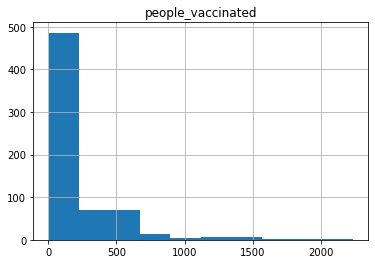

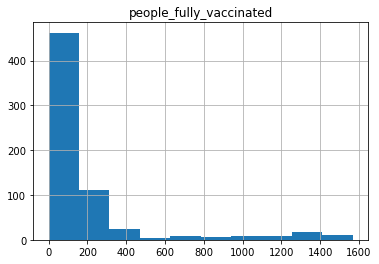

In [7]:
#Normalizing data on every country of ASEAN
#Following Procedure by https://www.statology.org/normalize-data-between-0-and-100/
#zi = (xi – min(x)) / (max(x) – min(x)) * 100

normalize = True #However, it may not be necessary like in this example: https://www.thoughtco.com/what-is-a-two-way-table-3126240
scale = 10000
if normalize:
    n = np.linalg.norm(covid_df['people_partially_vaccinated'])
    covid_df = covid_df.assign(people_partially_vaccinated = lambda x: x['people_partially_vaccinated']/n*scale)
    covid_df['people_partially_vaccinated'] = covid_df['people_partially_vaccinated'].round()
    n = np.linalg.norm(covid_df['people_fully_vaccinated'])
    covid_df = covid_df.assign(people_fully_vaccinated = lambda x: x['people_fully_vaccinated']/n*scale)
    covid_df['people_fully_vaccinated'] = covid_df['people_fully_vaccinated'].round()
    
covid_df.hist("people_partially_vaccinated",bins=20)
covid_df.hist("people_fully_vaccinated",bins=20)

Effectively this shows in a $n$ on every $100$ people type format.

In [8]:
def getSample(src_df, group_list, n):
    single = []
    full = []
    for i in range(len(group_list)):
        print('iso_code:',group_list[i])
        df = src_df[src_df['iso_code']==group_list[i]] #per country
        df = src_df[src_df['iso_code']==group_list[i]].sample(n)['vacc_state'].value_counts() #random sample by country
        print(df.index.size)
        for i in range(df.index.size):
            if(df.index[i] == 'Full'):
                full.append(df['Full'])
            if(df.index[i] == 'Partial'):
                single.append(df['Partial'])
        if len(single)<len(full):
            single.append(0)
        elif len(single)>len(full):
            full.append(0)
    return [single,full]
def state(a,b):
    if a<b:
        return "Full"
    else:
        return "Partial"

c = getSample(covid_df,covid_df['iso_code'].unique().tolist(),5)
single_vacc = c[0].copy()
full_vacc = c[1].copy()

print("covid_df iso_code:",covid_df['iso_code'].unique())
for i in range(covid_df['iso_code'].unique().size):
    print(covid_df['iso_code'].unique().tolist()[i],":",single_vacc[i],",",full_vacc[i],",",state(single_vacc[i],full_vacc[i]))

print("\n")

combined = [single_vacc,full_vacc]
#will make use of this: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html
chi = stat.chi2_contingency(combined)
print("chi2:",chi[0])
print("pval:",chi[1],"< 0.05 =",chi[1]<0.05)
print("dof:",chi[2])#should be 9 since df=(categories-1)(groups-1)=(2-1)(10-1)=1*9=9; 2categories, 10groups

#print("     partially vaccinated , fully vaccinated")
#for i in range(covid_df['iso_code'].unique().size):
    #print(covid_df['iso_code'].unique().tolist()[i],"=",chi[3][0][i],",",chi[3][1][i])

covid_df iso_code: ['BRN' 'KHM' 'IDN' 'LAO' 'MYS' 'MMR' 'PHL' 'SGP' 'THA' 'VNM']
single_vacc: [3.8684210526315788, 636.7459016393443, 70.632, 43.70454545454545, 102.8, 107.81451612903226, 317.3333333333333, 58.8, 194.54444444444445, 230.45945945945945]
full_vac: [0.8157894736842105, 681.9016393442623, 124.848, 29.59090909090909, 90.4, 80.12903225806451, 121.94444444444444, 89.4, 107.71111111111111, 9.108108108108109]


### 6. Insights and Conclusions

{CONENT}